In [203]:
import pandas as pd
import numpy as np

In [204]:
order = 50
states = 50
outputStates = 2
lookAhead = order-1
outputOrder = 7
lastPredictionAdj = lookAhead + outputOrder






In [205]:
def jsonToDataFrame(stockData):
    opens = []
    highs = []
    lows = []
    closes = []
    volumes = []
    dates = []

    for key in stockData:
        (open_, high, low, close, volume) = stockData[key]
        opens.append(open_)
        highs.append(high)
        lows.append(low)
        closes.append(close)
        volumes.append(volume)
        dates.append(key)

    data = {'Date':dates, 'Open':opens, 'High':highs, 'Low':lows, 'Close':closes, 'Volume': volumes}

    return pd.DataFrame(data=data)

In [206]:



def convertArrayToTimeSeries(array, duration):
    length = len(array) - duration
    if(length <= 0):
        return np.ndarray((0,duration))

    subTimeSeries = np.ndarray((length, duration))
    for i in range(0, length):
        subTimeSeries[i] = array[i:i+duration]
    return subTimeSeries

def normalizeTimeSerie(timeSerie):
    avg = np.mean(timeSerie)
    var = np.var(timeSerie)
    if(var == 0):
        return np.zeros(timeSerie.shape)
    else:
        return (timeSerie - avg)/var

def normalizeTimeSeries(timeSeries):
    avg = np.mean(timeSeries, axis=1)
    var = np.var(timeSeries, axis=1)
    

    timeSeriesNorm = np.ndarray(timeSeries.shape)
    for i in range(len(timeSeries)):
        if(var[i] == 0):
            timeSeriesNorm[i] = np.zeros(timeSeries[i].shape)
        else:
            timeSeriesNorm[i] = (timeSeries[i] - avg[i])/var[i]
            maxNorm = np.max(timeSeriesNorm[i])
            minNorm = np.min(timeSeriesNorm[i])
            timeSeriesNorm[i] = (timeSeriesNorm[i]-minNorm)/(maxNorm-minNorm)


    return timeSeriesNorm




In [207]:
from convertStockToJson import getJsonDataFromFile

def loadTimeSeriesNormalized(name, inputDuration, outputDuration):
    stockData = getJsonDataFromFile(name)
    stockDatadf = jsonToDataFrame(stockData) 
    inputTimeSeries = convertArrayToTimeSeries(stockDatadf['Close'], inputDuration)
    outputTimeSeries = convertArrayToTimeSeries(stockDatadf['Close'], outputDuration)
    inputTimeSeriesNorm = normalizeTimeSeries(inputTimeSeries)
    outputTimeSeriesNorm = normalizeTimeSeries(outputTimeSeries)

    return (inputTimeSeriesNorm, outputTimeSeriesNorm, inputTimeSeries, outputTimeSeries, stockDatadf)

In [208]:
def loadTimeSeriesNormalizedMultiple(names, inputDuration, outputDuration):
    closes = []
    for name in names:
        stockData = getJsonDataFromFile(name)
        stockDatadf = jsonToDataFrame(stockData) 
        closes.extend(stockDatadf['Close'])
        inputTimeSeries = convertArrayToTimeSeries(closes, inputDuration)
        outputTimeSeries = convertArrayToTimeSeries(closes, outputDuration)
        inputTimeSeriesNorm = normalizeTimeSeries(inputTimeSeries)
        outputTimeSeriesNorm = normalizeTimeSeries(outputTimeSeries)

    return (inputTimeSeriesNorm, outputTimeSeriesNorm, inputTimeSeries, outputTimeSeries, stockDatadf)

In [209]:
from sklearn.cluster import KMeans
import numpy as np
import numpy as np
import matplotlib.pyplot as plt


stockNameTrainedOn = 'VAS'
stockNameTrainedOns = ['VAS', 'IOO', 'ANZ','NAB','TLS','QAN']
subTimeSeriesNormsBIG = []
subTimeSeriesNorms = []
outputTimeSeriesNorms = []
for name in stockNameTrainedOns:
    (subTimeSeriesNorm, outputTimeSeriesNorm, subTimeSeries, outputTimeSeries, stockDatadf) =       loadTimeSeriesNormalizedMultiple(stockNameTrainedOns, order, outputOrder)
    subTimeSeriesNormsBIG.extend(subTimeSeriesNorm)
    subTimeSeriesNorms.append(subTimeSeriesNorm)
    outputTimeSeriesNorms.append(outputTimeSeriesNorm)


print(len(subTimeSeriesNormsBIG))


kmeans = KMeans(n_clusters=states, random_state=0).fit(subTimeSeriesNormsBIG)
cluserCenters = kmeans.cluster_centers_

# for cluster in cluserCenters:
#     plt.plot(cluster)
#     plt.show()






63336


In [210]:
maxChange = max(-np.min(cluserCenters), np.max(cluserCenters))
increaseData = np.linspace(-maxChange, maxChange, outputOrder)
mid = np.zeros(outputOrder)
decreaceData = np.linspace(maxChange, -maxChange, outputOrder)

dummyData = np.array([increaseData, decreaceData])


outputKMeans = KMeans(n_clusters=outputStates, random_state=0).fit(dummyData)
outputKMeans.cluster_centers_



array([[-9.86877331e-01, -6.57918221e-01, -3.28959110e-01,
         1.11022302e-16,  3.28959110e-01,  6.57918221e-01,
         9.86877331e-01],
       [ 9.86877331e-01,  6.57918221e-01,  3.28959110e-01,
        -1.11022302e-16, -3.28959110e-01, -6.57918221e-01,
        -9.86877331e-01]])

In [211]:
outputsTransform = outputKMeans.transform(outputTimeSeriesNorm).transpose()
minOutPutTransform = np.min(outputsTransform, axis=1)
maxOutPutTransform = np.max(outputsTransform, axis=1)
print(minOutPutTransform)
print(maxOutPutTransform)

[1.2413486  1.23336212]
[3.35642438 3.32944602]


In [212]:

buysOrSells = np.zeros(outputStates) 
buysOrSells[0] = 1
buysOrSells[1] = -1
# buysOrSells[2] = 0

In [213]:
def predictStateVector(timeSerieNorm, kmeans):
    if len(kmeans.cluster_centers_) == outputStates:
        distances = kmeans.transform([timeSerieNorm])[0]
        return 1-(distances-minOutPutTransform)/(maxOutPutTransform-minOutPutTransform)
    else:
        distances = kmeans.transform([timeSerieNorm])[0]
        minDis = np.min(distances)
        maxDis = np.max(distances)
        distances -= minDis
        distances /= maxDis
        distances = 1 - distances
        distances = distances * distances * distances
        return distances


def predictStatesVector(timeSerieNorms, kmeans):
    result = np.zeros((timeSerieNorms.shape[0], len(kmeans.cluster_centers_)))
    for i in range(len(timeSerieNorms)):
        result[i] = predictStateVector(timeSerieNorms[i], kmeans)
    return result

    distances = kmeans.transform(timeSerieNorms)
    minDis = np.min(distances, axis=1)
    maxDis = np.max(distances, axis=1)
    for i in range(len(distances)):
        distances[i] -= minDis[i]
        distances[i] /= maxDis[i]
        distances[i] = 1 - distances[i]
        distances[i] = distances[i] * distances[i] * distances[i]
    return distances

def valuateOuput(timeSerieNorms):
    value = np.zeros(len(timeSerieNorms))
    for i in range(len(timeSerieNorms)):
        value[i] = timeSerieNorms[i][-1] - timeSerieNorms[i][0]
        
    return value

    

In [259]:
transitionProbabilities = np.zeros((states, outputStates))

transitionCounts = np.zeros((states, outputStates))

transitionStateCounts = np.zeros(states)


def trainMarkokChain(timeSeriesNormalized, outTSNorm):
    global transitionCounts, transitionStateCounts, transitionProbabilities

    subSeriesClassifified = kmeans.predict(subTimeSeriesNorm)
    outSeriesClassified = outputKMeans.predict(outTSNorm)

    for i in range(len(subSeriesClassifified)-lookAhead):
        currentState = subSeriesClassifified[i]
        nextState = outSeriesClassified[i+lookAhead]
        
        transitionCounts[currentState, nextState] += 1
        transitionStateCounts[currentState] += 1

def trainMarkokChainContinous(timeSeriesNormalized, outTSNorm):
    global transitionCounts, transitionStateCounts, transitionProbabilities
   
    transitionProbabilities = np.zeros(transitionProbabilities.shape)
    transitionCounts = np.zeros(transitionCounts.shape)
    transitionStateCounts = np.zeros(transitionStateCounts.shape)

    timeSeriesKMeanDistances = predictStatesVector(timeSeriesNormalized, kmeans)
    outputTSKMeanDistances = predictStatesVector(outTSNorm, outputKMeans)



    transitionCountsT = transitionCounts.transpose()
    for i in range(len(timeSeriesKMeanDistances)-lookAhead):
        currentState = timeSeriesKMeanDistances[i]
        nextState = outputTSKMeanDistances[i+lookAhead]
        for i in range(len(nextState)):
            adjust = currentState * nextState[i]
            transitionCountsT[i] += adjust
    transitionCounts = transitionCountsT.transpose()
        
    transitionStateCounts = np.sum(transitionCounts, axis=1)

def trainMarkokChainContinousAlt(timeSeriesNormalized, outTSNorm):
    global transitionCounts, transitionStateCounts, transitionProbabilities
   
    transitionProbabilities = np.zeros(transitionProbabilities.shape)
    transitionCounts = np.zeros(transitionCounts.shape)
    transitionStateCounts = np.zeros(transitionStateCounts.shape)

    timeSeriesKMeanDistances = predictStatesVector(timeSeriesNormalized, kmeans)

    for i in range(len(timeSeriesKMeanDistances)-lookAhead):
        currentState = timeSeriesKMeanDistances[i]
        tsNorm = outTSNorm[i+lookAhead]
        dif = tsNorm[-1] - tsNorm[0]
        if(dif > 0):
            for j in range(len(currentState)):
                transitionCounts[j][0] += currentState[j] * dif
        else:
            for j in range(len(currentState)):
                transitionCounts[j][1] += currentState[j] * -dif
      
        
        
    transitionStateCounts = np.sum(transitionCounts, axis=1)



for (subTimeSeriesNorm, outputTimeSeriesNorm) in zip(subTimeSeriesNorms, outputTimeSeriesNorms):
    #trainMarkokChain(subTimeSeriesNorm, outputTimeSeriesNorm)
    trainMarkokChainContinous(subTimeSeriesNorm, outputTimeSeriesNorm)
    #trainMarkokChainContinousAlt(subTimeSeriesNorm, outputTimeSeriesNorm)

print(transitionCounts)

[[1822.82150896 1613.7085366 ]
 [1906.85566404 1705.17634038]
 [1950.37348815 1815.61782012]
 [1543.87557556 1375.81379287]
 [1453.54865561 1276.7878996 ]
 [1999.38923318 1837.98288257]
 [2255.82630913 2047.59478476]
 [2198.86499364 1975.26870742]
 [1825.63792561 1609.245829  ]
 [1821.35455622 1601.80670084]
 [1846.75370395 1657.00787998]
 [2048.58280303 1866.30588969]
 [2016.69389374 1850.88493281]
 [2218.09200204 2033.35088193]
 [1861.69851863 1652.10453334]
 [1506.65066491 1336.35933691]
 [1860.27101223 1652.9513052 ]
 [1692.47776966 1522.53990628]
 [1851.75536173 1660.38373509]
 [1742.21540003 1533.85408306]
 [1851.21691897 1668.81182071]
 [1809.0041563  1647.02369885]
 [1731.05523185 1510.59166284]
 [1883.93724187 1641.18961564]
 [1272.96080748 1123.05350957]
 [1831.53824175 1648.63897104]
 [1933.60946876 1711.80283571]
 [2014.02273242 1797.45734632]
 [1629.50455639 1480.92468238]
 [1883.53406882 1697.31340224]
 [1924.68177417 1744.06384227]
 [1909.10875071 1704.7883124 ]
 [1759.5

In [260]:
def updateProbabilities():
    for i in range(transitionProbabilities.shape[0]):
        if(transitionStateCounts[i] != 0):
            for j in range(transitionProbabilities.shape[1]):
                transitionProbabilities[i, j] = transitionCounts[i, j]/transitionStateCounts[i]

updateProbabilities()
print(transitionProbabilities)

[[0.53042502 0.46957498]
 [0.52791771 0.47208229]
 [0.51789113 0.48210887]
 [0.52878076 0.47121924]
 [0.53236977 0.46763023]
 [0.52103084 0.47896916]
 [0.52419372 0.47580628]
 [0.52678356 0.47321644]
 [0.53149919 0.46850081]
 [0.532068   0.467932  ]
 [0.52707745 0.47292255]
 [0.52327996 0.47672004]
 [0.52143576 0.47856424]
 [0.52172687 0.47827313]
 [0.52982438 0.47017562]
 [0.52994913 0.47005087]
 [0.52950563 0.47049437]
 [0.52642876 0.47357124]
 [0.52724431 0.47275569]
 [0.5318005  0.4681995 ]
 [0.5259096  0.4740904 ]
 [0.52343448 0.47656552]
 [0.53400487 0.46599513]
 [0.53443105 0.46556895]
 [0.53128264 0.46871736]
 [0.52627729 0.47372271]
 [0.53042271 0.46957729]
 [0.52840962 0.47159038]
 [0.52388414 0.47611586]
 [0.52600232 0.47399768]
 [0.52461576 0.47538424]
 [0.52826871 0.47173129]
 [0.52895082 0.47104918]
 [0.52994443 0.47005557]
 [0.53468304 0.46531696]
 [0.531183   0.468817  ]
 [0.52097096 0.47902904]
 [0.52394577 0.47605423]
 [0.52178076 0.47821924]
 [0.51953653 0.48046347]


def loadTimeSeriesClassified(name, inputDuration, outputDuration):
    normalized = loadTimeSeriesNormalized(name, inputDuration, outputDuration)
    return (normalized, True)
    if(normalized.shape[0] > 0):
        return (kmeans.predict(normalized), True)
    else:
        return (None, False)

def testMarkovChain(subSeriesClassifified, outTSNorm):
    numCorrect = 0
    length = len(subSeriesClassifified)-lookAhead
    for i in range(length):
        currentState = subSeriesClassifified[i]
        nextStateCorrect = outTSNorm[i+lookAhead]
        nextStatePredict = np.argmax(transitionStateCounts[currentState])
        if(nextStatePredict == nextStateCorrect):
            numCorrect += 1
    if(length > 0):
        return numCorrect/length
    else:
        return None

from filesInPath import filesInPath

filenames = filesInPath('data')
import random

# random.shuffle(filenames)
# filenames = filenames[:40]
filenames = ['VAS', 'IOO', 'XRO', 'ANZ']

for (fileName,i) in zip(filenames, range(len(filenames))):
    #fileName = fileName[:-5]
 
    ((inputTS, outPutTs), success) = loadTimeSeriesClassified(fileName, order, outputOrder)  
    if(success):  
        percetage = testMarkovChain(inputTS, outPutTs)  
        if(percetage != None):
            print(fileName + ",  " + str(percetage * 100 ) + "%")


In [261]:

def shouldBuyorSells(timeSeries):
    timeSerieNorms = normalizeTimeSeries(timeSeries)
    rankings = predictStatesVector(timeSerieNorms, kmeans)
    return np.dot(rankings, np.dot(transitionProbabilities, buysOrSells))



def shoudlBuyorSell(timeSerie):
    distinct = False
    if distinct :
        currentState = kmeans.predict(normalizeTimeSeries(np.array([timeSerie])))[0]
        nextState = np.argmax(transitionProbabilities[currentState])
        return buysOrSells[nextState]
    else:
        #currentState = kmeans.predict(normalizeTimeSeries(np.array([timeSerie])))[0]
        timeSerieNorm = normalizeTimeSeries(np.array([timeSerie]))[0]
        rankings = predictStateVector(timeSerieNorm, kmeans)
        return np.dot(rankings, np.dot(transitionProbabilities, buysOrSells) )


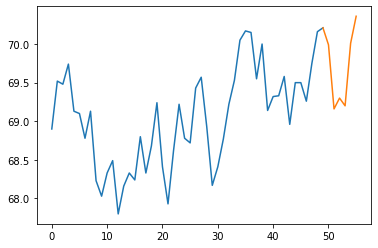

1.0875531840324038
[[2.34518662 2.46598081]]
[0.47810947 0.4119421 ]


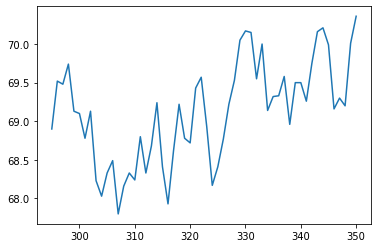

In [262]:
def plotSample():
    (subTimeSeriesNorm, outputTimeSeriesNorm, subTimeSeries, outputTimeSeries, stockDatadf) = loadTimeSeriesNormalized(stockNameTrainedOn, order, outputOrder)
    i = 295
    sample = subTimeSeries[i]
    sampleNorm = subTimeSeriesNorm[i]
    answer = outputTimeSeries[i+lookAhead]
    answerNorm = outputTimeSeriesNorm[i+lookAhead]
    plt.plot(np.arange(len(sample)),sample)
    plt.plot(np.arange(lookAhead, lookAhead+len(answer)),answer)
    plt.show()
    print(shoudlBuyorSell(sample))
   #print(outputKMeans.predit([normalizeTimeSerie(answer)]))
    print(outputKMeans.transform([answerNorm]))
    print(predictStateVector(answerNorm, outputKMeans))

    plt.plot(stockDatadf['Close'][i:i+lookAhead+outputOrder])
    plt.show()
plotSample()

In [278]:
def runModelAgainst(subTimeSeries, threshold, callback=None):
    principle = 1000
    buyingPower = principle
    stocks = 0
    investedAmount = 0
    onlySellWhenHigher = False
    daysShouldWaitToSell = None

    for i in range(len(subTimeSeries)):
        stockPrice = subTimeSeries[i][-1]
        stockPosition = stocks*stockPrice
        stockAmount = int(buyingPower/stockPrice)
        cost = stockAmount * stockPrice 

        signal = shoudlBuyorSell(subTimeSeries[i])
        didBuy = False
        didSell = False
        
        if(daysShouldWaitToSell == None):
            if(signal > threshold):
                #should buy
                if(stockAmount > 0):
                    #buy
                    investedAmount += cost
                    buyingPower -= cost
                    stocks += stockAmount
                    daysShouldWaitToSell = outputOrder
                    didBuy = True


        elif(daysShouldWaitToSell == 0):
            #should sell
            if(stocks > 0): # and (investedAmount < stockPosition or not onlySellWhenHigher)):
                investedAmount -= stockPosition
                buyingPower += stockPosition
                stocks = 0
                daysShouldWaitToSell = None
                didSell = True
        else:
            daysShouldWaitToSell -= 1
        
        if(callback != None):
            callback((i, didBuy, didSell, buyingPower, stocks, investedAmount, daysShouldWaitToSell, stockPrice, stockPosition, stockAmount, cost, signal))

    buyingPower += stocks*stockPrice
    stocks = 0

    return buyingPower


def runModelAgainst(subTimeSeries, threshold, callback=None):
    principle = 1000
    buyingPower = principle
    stocks = 0
    investedAmount = 0
    onlySellWhenHigher = False
    daysShouldWaitToSell = None
    boughtFor = None
    stopGain = 0.05
    stopLoss = -0.03

    for i in range(len(subTimeSeries)):
        stockPrice = subTimeSeries[i][-1]
        stockPosition = stocks*stockPrice
        stockAmount = int(buyingPower/stockPrice)
        cost = stockAmount * stockPrice 

        signal = shoudlBuyorSell(subTimeSeries[i])
        didBuy = False
        didSell = False

        profitLoss =  (stockPosition/boughtFor)-1 if boughtFor!=None else None

        
        if(boughtFor == None):
            if(signal > threshold):
                #should buy
                if(stockAmount > 0):
                    #buy
                    investedAmount += cost
                    buyingPower -= cost
                    stocks += stockAmount
                    didBuy = True
                    boughtFor = cost


        elif(profitLoss > stopGain or profitLoss < stopLoss):
            #should sell
            if(stocks > 0): # and (investedAmount < stockPosition or not onlySellWhenHigher)):
                investedAmount -= stockPosition
                buyingPower += stockPosition
                stocks = 0
                boughtFor = None
                didSell = True
        
        if(callback != None):
            callback((i, didBuy, didSell, buyingPower, stocks, investedAmount, daysShouldWaitToSell, stockPrice, stockPosition, stockAmount, cost, signal))

    buyingPower += stocks*stockPrice
    stocks = 0

    return buyingPower


def runModelAgainst(subTimeSeries, threshold, callback=None):
    principle = 1000
    buyingPower = principle
    stocks = 0
    investedAmount = 0
    onlySellWhenHigher = False
    daysShouldWaitToSell = None
    boughtFor = None
    stopGain = 0.1
    stopLoss = -0.03
    sellThreshold = 1.5

    for i in range(len(subTimeSeries)):
        stockPrice = subTimeSeries[i][-1]
        stockPosition = stocks*stockPrice
        stockAmount = int(buyingPower/stockPrice)
        cost = stockAmount * stockPrice 

        signal = shoudlBuyorSell(subTimeSeries[i])
        didBuy = False
        didSell = False

        profitLoss =  (stockPosition/boughtFor) - 1 if boughtFor!=None else None
        
        if(boughtFor == None):
            if(signal > threshold):
                #should buy
                if(stockAmount > 0):
                    #buy
                    investedAmount += cost
                    buyingPower -= cost
                    stocks += stockAmount
                    didBuy = True
                    boughtFor = cost


        elif(profitLoss > stopGain or profitLoss < stopLoss or sellThreshold > signal):
            #should sell
            if(stocks > 0): # and (investedAmount < stockPosition or not onlySellWhenHigher)):
                investedAmount -= stockPosition
                buyingPower += stockPosition
                stocks = 0
                boughtFor = None
                didSell = True
        
        if(callback != None):
            callback((i, didBuy, didSell, buyingPower, stocks, investedAmount, daysShouldWaitToSell, stockPrice, stockPosition, stockAmount, cost, signal))

    buyingPower += stocks*stockPrice
    stocks = 0

    return buyingPower

In [279]:
def thresholdRange(subTimeSeries, steps = 20):
    signals = np.ndarray((len(subTimeSeries)))
   
    for i in range(len(subTimeSeries)):
        signals[i] = shoudlBuyorSell(subTimeSeries[i])
    
    minSig = np.min(signals)
    maxSig = np.max(signals)
    print(minSig)
    print(maxSig)
    if(minSig == maxSig):
        return [minSig]
    else:
        return np.arange(minSig, maxSig, (maxSig-minSig)/steps)



In [280]:

stockPriceHistory = jsonToDataFrame(getJsonDataFromFile('CBA'))['Close']

subTimeSeries = convertArrayToTimeSeries(stockPriceHistory, order)[:-365]

In [281]:


bestthreshold = -np.inf
bestPrice = -np.inf
print(thresholdRange(subTimeSeries))
for threshold in thresholdRange(subTimeSeries):
    price = runModelAgainst(subTimeSeries, threshold)
    if(bestPrice < price):
        bestPrice = price
        bestthreshold = threshold
    print((price, threshold))

0.49901061475458924
1.6091949707732598
[0.49901061 0.55451983 0.61002905 0.66553827 0.72104749 0.7765567
 0.83206592 0.88757514 0.94308436 0.99859357 1.05410279 1.10961201
 1.16512123 1.22063045 1.27613966 1.33164888 1.3871581  1.44266732
 1.49817654 1.55368575]
0.49901061475458924
1.6091949707732598
(1177.7999999999965, 0.49901061475458924)
(1190.73, 0.5545198325555227)
(1762.7400000000007, 0.6100290503564563)
(911.5600000000021, 0.6655382681573897)
(1227.6499999999992, 0.7210474859583231)
(863.1500000000001, 0.7765567037592567)
(1135.2700000000002, 0.8320659215601902)
(1152.3199999999995, 0.8875751393611236)
(1350.7600000000011, 0.9430843571620571)
(1073.6999999999996, 0.9985935749629906)
(1117.8699999999992, 1.0541027927639242)
(790.3800000000002, 1.1096120105648575)
(706.9399999999998, 1.165121228365791)
(892.82, 1.2206304461667246)
(983.6500000000001, 1.276139663967658)
(1045.0900000000001, 1.3316488817685914)
(1084.21, 1.387158099569525)
(1044.97, 1.4426673173704585)
(961.5000000

In [282]:

def trackModel(threshold):
    equity = np.zeros(len(subTimeSeries))
    monies = np.zeros(len(subTimeSeries))
    stockOverTime = np.zeros(len(subTimeSeries))
    buys = []
    hasBuys = [False]
    sells = []
    hasSells = [False]
    stockPrices = []
    signals = []
    def record(state):
        (i, didBuy, didSell, buyingPower, stocks, investedAmount, daysShouldWaitToSell, stockPrice, stockPosition, stockAmount, cost, signal) = state
        buys.append(stockPrice if didBuy else None)
        sells.append(stockPrice if didSell else None)
        if(didBuy):
            hasBuys[0] = True
        if(didSell):
            hasSells[0] = True
        stockPrices.append(stockPrice)
        signals.append(signal)
        equity[i] = buyingPower + stocks*stockPrice
        monies[i] = buyingPower
        stockOverTime[i] = stocks*stockPrice

    runModelAgainst(subTimeSeries, threshold, record)

    plt.plot(equity)
    plt.xlabel('Time (days)')
    plt.ylabel('Equity ($)')
    plt.show()

    plt.plot(monies, c='blue')
    plt.plot(stockOverTime, c='red')
    plt.show()

    fig,ax = plt.subplots()
    ax.plot(stockPrices)
    ax.set_ylabel("Stock Price ($)")
    ax.set_xlabel("Time (days)")
    if(hasBuys[0]):
        ax.scatter(np.arange(len(buys)), buys, c='green')
    if(hasSells[0]):
        ax.scatter(np.arange(len(sells)), sells, c='red')
    ax2=ax.twinx()
    ax2.plot(signals,c='black', alpha=0.2)
    ax2.plot([0, len(signals)-1], [threshold, threshold], c='red', alpha=0.2)
    ax2.set_ylabel('Signal, Future Prediction')
    fig.show()
    plt.show()

    plt.plot(signals)
    plt.show()

0.49901061475458924
1.6091949707732598
1.4241642447701484


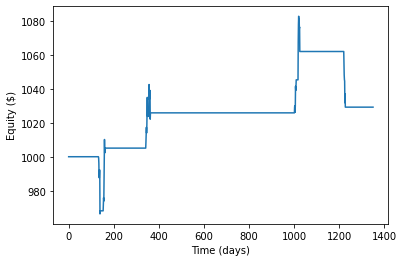

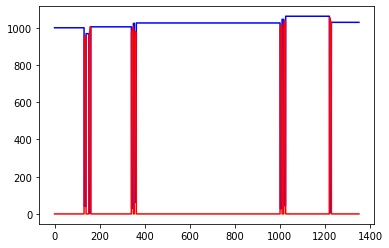

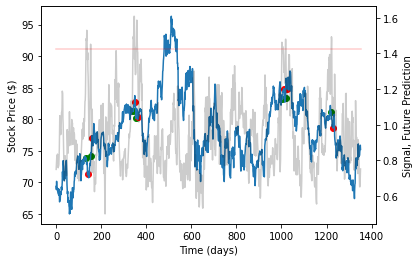

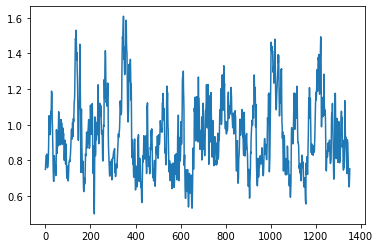

1.2391335187670365


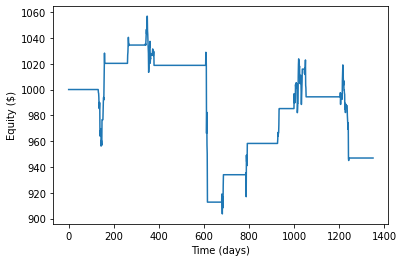

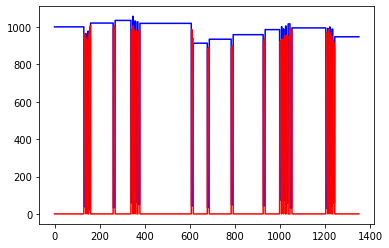

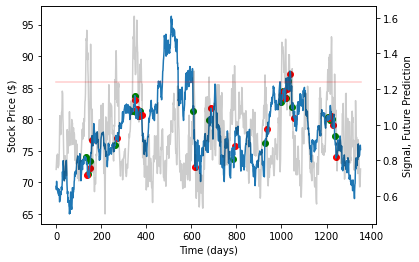

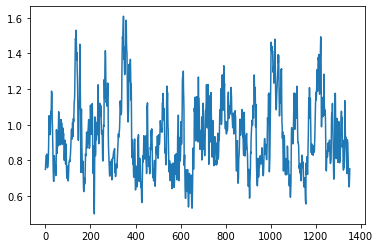

1.0541027927639246


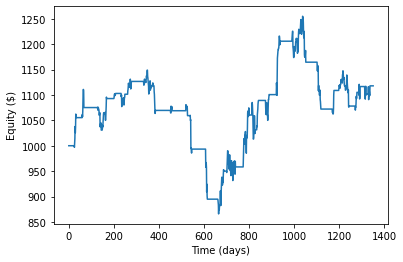

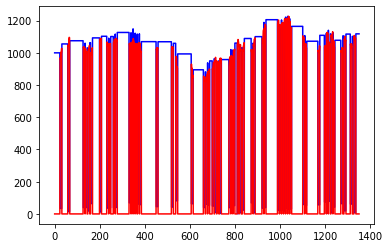

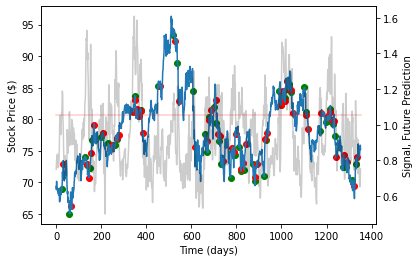

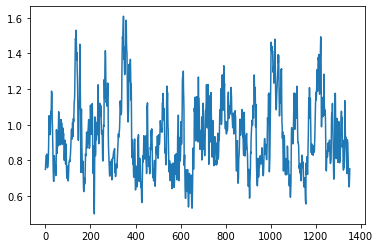

0.869072066760813


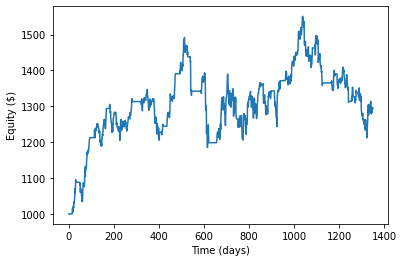

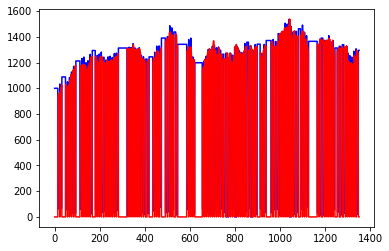

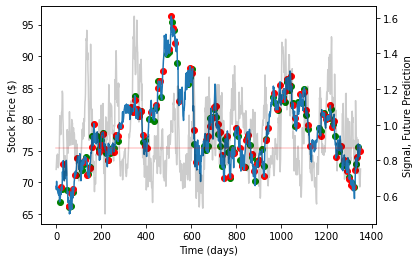

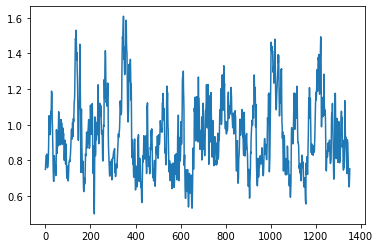

0.6840413407577011


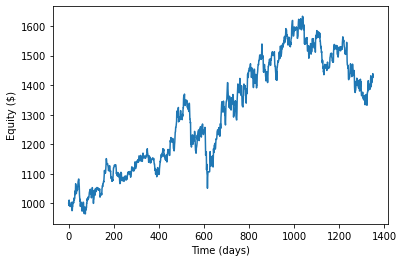

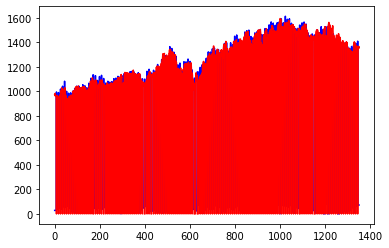

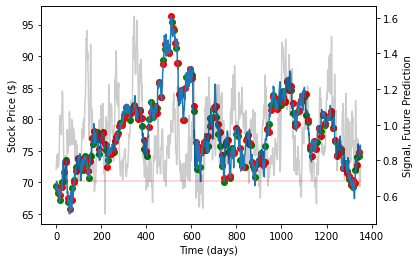

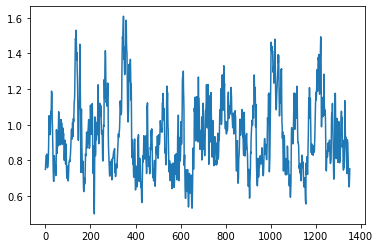

0.49901061475458924


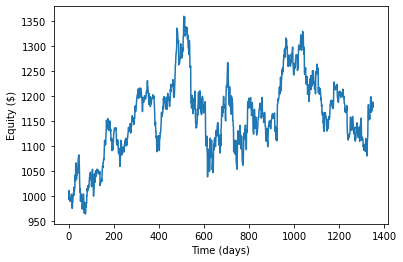

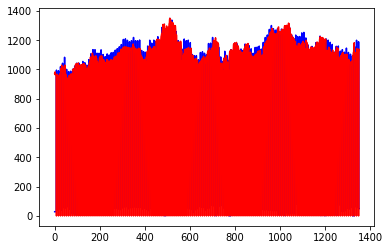

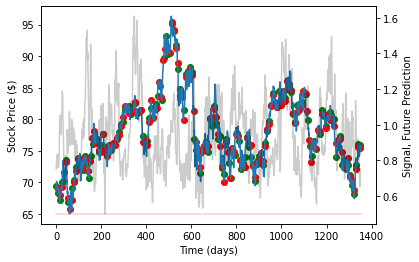

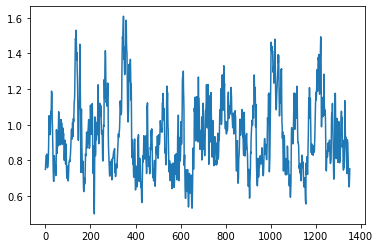

In [283]:
for threshold in thresholdRange(subTimeSeries, 6)[::-1]:
    print(threshold)
    trackModel(threshold)

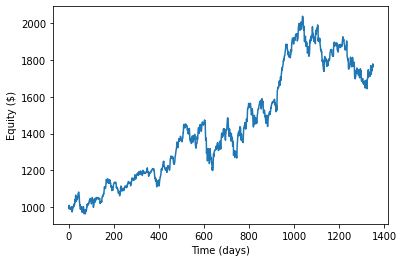

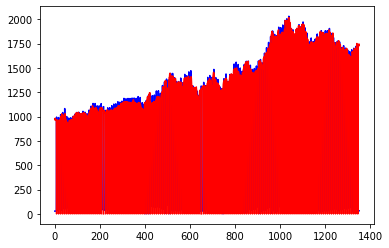

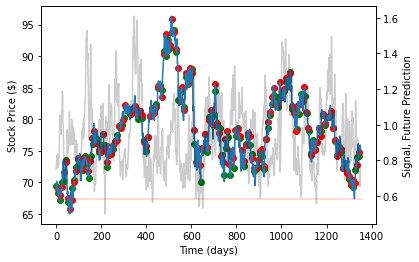

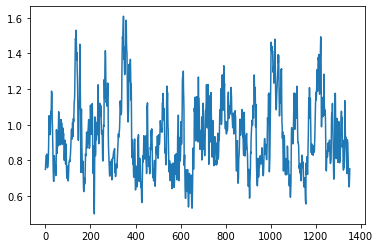

In [284]:
trackModel(0.58)

0.49901061475458924
1.6091949707732598


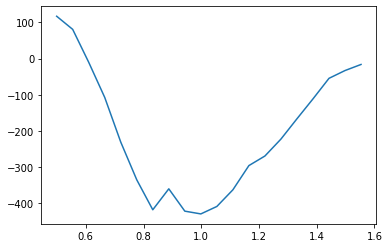

In [285]:
def effectivity(threshold):
    buys = []
    sells = []
    stockPrices = []
    signals = []
    profits = []

    for i in range(len(subTimeSeries) - lastPredictionAdj):
        stockPrice = subTimeSeries[i][-1]
        stockPriceFuture = subTimeSeries[i+lastPredictionAdj][-1]
        signal = shoudlBuyorSell(subTimeSeries[i])

        buys.append(None)
        sells.append(None)
        stockPrices.append(stockPrice)
        signals.append(signal)
        profits.append(0)
        if(signal > threshold):
            #buy
            buys[i] = stockPrice  
            profit = stockPriceFuture - stockPrice
            profits[i] = profit


    return np.sum(profits)


profits = []
thresholds = []
for threshold in thresholdRange(subTimeSeries, 20)[::-1]:
    profits.append(effectivity(threshold))
    thresholds.append(threshold)

plt.plot(thresholds, profits)
plt.show()